# A Gentle Introduction to the Box-Jenkins Method for Time Series Forecasting

The Autoregressive Integrated Moving Average Model, or ARIMA for short is a standard statistical model for time series forecast and analysis.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

   * AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
   * I: Integrated. The use of differencing of raw observations (i.e. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
   * MA: Moving Average. A model that uses the dependency between an observation and residual errors from a moving average model applied to lagged observations.

The parameters of the ARIMA model are defined as follows:

   * p: The number of lag observations included in the model, also called the lag order.
   * d: The number of times that the raw observations are differenced, also called the degree of differencing.
   * q: The size of the moving average window, also called the order of moving average.



The 2016 5th edition of the textbook (Part Two, page 177) refers to the process as a stochastic model building and that it is an iterative approach that consists of the following 3 steps:

   * Identification. Use the data and all related information to help select a sub-class of model that may best summarize the data.
   * Estimation. Use the data to train the parameters of the model (i.e. the coefficients).
   * Diagnostic Checking. Evaluate the fitted model in the context of the available data and check for areas where the model may be improved. (check for overfitting/residual errors)


In [1]:
! curl -o shampoo-sales.csv https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   519  100   519    0     0   2011      0 --:--:-- --:--:-- --:--:--  2011


Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


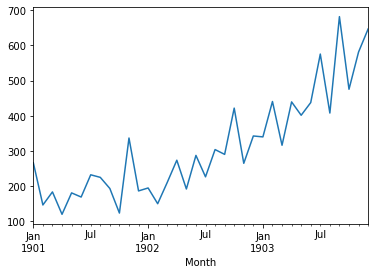

In [3]:
from pandas import datetime
from pandas import read_csv
from matplotlib import pyplot
 
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
series.plot()
pyplot.show()

This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

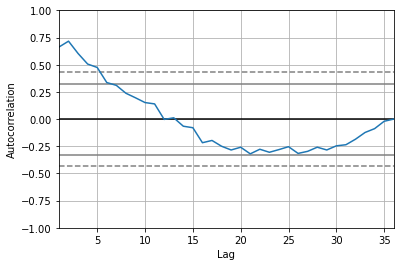

In [4]:
from pandas.plotting import autocorrelation_plot
 
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
autocorrelation_plot(series)
pyplot.show()

Running the example, we can see that there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.

An ARIMA model can be created using the statsmodels library as follows:

  *  Define the model by calling ARIMA() and passing in the p, d, and q parameters.
  *  The model is prepared on the training data by calling the fit() function.
  *  Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.



/home/henri/miniconda2/envs/NNScraper/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/henri/miniconda2/envs/NNScraper/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Mon, 09 Nov 2020   AIC                            406.340
Time:                        18:21:41   BIC                            417.227
Sample:                    02-01-1901 

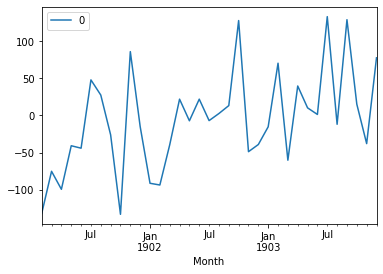

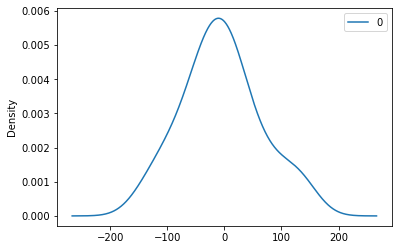

                0
count   35.000000
mean    -5.495171
std     68.132885
min   -133.296560
25%    -42.477880
50%     -7.186528
75%     24.748386
max    133.237992


In [5]:
from  pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
 
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary()) # This summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations.
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot() # First, we get a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.
pyplot.show()
residuals.plot(kind='kde') # Next, we get a density plot of the residual error values, suggesting the errors are Gaussian, but may not be centered on zero.
pyplot.show()
print(residuals.describe()) #The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

## Rolling Forecast ARIMA Model

The ARIMA model can be used to forecast future time steps.

predicted=349.117678, expected=342.300000
predicted=306.512928, expected=339.700000
predicted=387.376449, expected=440.400000
predicted=348.154170, expected=315.900000
predicted=386.308793, expected=439.300000
predicted=356.082001, expected=401.300000
predicted=446.379478, expected=437.400000
predicted=394.737264, expected=575.500000
predicted=434.915649, expected=407.600000
predicted=507.923416, expected=682.000000
predicted=435.482886, expected=475.300000
predicted=652.743865, expected=581.300000
predicted=546.343437, expected=646.900000
Test MSE: 6958.329


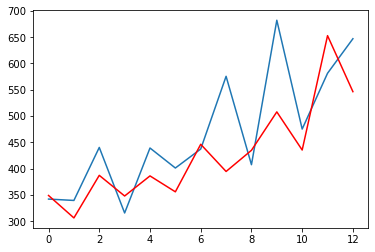

In [6]:
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()